# Train a deep SNN on the SHD Dataset

In [1]:
import os
import sys

sys.path.append("../../stork")

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns


import stork
from stork.datasets import HDF5Dataset, DatasetView

from stork.loss_stacks import SumOfSoftmaxCrossEntropy
from stork.layers import Layer
from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, LIFGroup, AdaptLearnLIFGroup
from stork.connections import Connection
from stork.generators import StandardGenerator
from stork.initializers import (
    FluctuationDrivenCenteredNormalInitializer,
    DistInitializer,
)

## Load Dataset

***To locally run this notebook on your system, download the SHD dataset from: [https://zenkelab.org/datasets/](https://zenkelab.org/datasets/).***
*We need 'shd_train.h5' and 'shd_test.h5'. Move the downloaded files into a folder `data/datasets/hdspikes` in this repo, or change the `datadir` variable below. 

In [2]:
datadir = "/tungstenfs/scratch/gzenke/datasets/hdspikes"

Next, we specify the Dataset Parameters.

In [3]:
nb_inputs = 700
duration = 0.7
time_step = dt = 2e-3
nb_time_steps = int(duration / time_step)
time_scale = 1
unit_scale = 1
validation_split = 0.9

sigma_u_augment = 10
dropout_p = 0.4

In [4]:
train_gen_kwargs = dict(
    nb_steps=nb_time_steps,
    time_scale=time_scale / time_step,
    unit_scale=unit_scale,
    nb_units=nb_inputs,
    preload=True,
    precompute_dense=False,
    unit_permutation=None,
    sigma_u_uniform=sigma_u_augment,
)

test_gen_kwargs = dict(
    nb_steps=nb_time_steps,
    time_scale=time_scale / time_step,
    unit_scale=unit_scale,
    nb_units=nb_inputs,
    preload=True,
    precompute_dense=False,
    unit_permutation=None,
    sigma_u_uniform=0,
)

In [5]:
train_dataset = HDF5Dataset(os.path.join(datadir, "shd_train.h5"), **train_gen_kwargs)

# Split into train and validation set
mother_dataset = train_dataset
elements = np.arange(len(mother_dataset))
np.random.shuffle(elements)
split = int(validation_split * len(mother_dataset))
valid_dataset = DatasetView(mother_dataset, elements[split:])
train_dataset = DatasetView(mother_dataset, elements[:split])

test_dataset = HDF5Dataset(os.path.join(datadir, "shd_test.h5"), **test_gen_kwargs)

## Set up the model

In [6]:
# Model Parameters
batch_size = 256
beta = 5
device = torch.device("cuda:0")
dtype = torch.float

nb_hidden_units = 1024
nb_hidden_layers = 1
nb_classes = 20
rec = True
stochastic = True
nb_readouts = 1

tau_mem = 20e-3
tau_syn = 10e-3
tau_readout = 200e-3

init_hetero = True
learn_tau_mem = False
learn_tau_syn = False
learn_tau_mem_hetero = False
learn_tau_syn_hetero = False

if learn_tau_mem_hetero:
    learn_tau_mem = True
    init_hetero = False
if learn_tau_syn_hetero:
    learn_tau_syn = True
    init_hetero = False

lr = 5e-3
nb_epochs = 100

In [7]:
act_fn = stork.activations.SuperSpike
act_fn.beta = beta
neuron_group = AdaptLearnLIFGroup

model = RecurrentSpikingModel(batch_size, nb_time_steps, nb_inputs, device, dtype)

Create regularizers

In [8]:
# Define regularizer parameters (set regularizer strenght to 0, if you don't want to use them)
lowerBoundL2Strength = 100
lowerBoundL2Threshold = 1e-3
upperBoundL2Strength = 0
upperBoundL2Threshold = (
    7  # Regularizes spikecount: 7 spikes ~ 10 Hz in 700ms simulation time
)
weightL2Strength = 1e-3

# Define regularizer list
regs = []

regLB = stork.regularizers.LowerBoundL2(
    lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False
)
if lowerBoundL2Strength > 0:
    regs.append(regLB)

regUB = stork.regularizers.UpperBoundL2(
    upperBoundL2Strength, threshold=upperBoundL2Threshold, dims=1
)
if upperBoundL2Strength > 0:
    regs.append(regUB)

w_regs = []

regw = stork.regularizers.WeightL2Regularizer(strength=weightL2Strength)
if weightL2Strength > 0:
    w_regs.append(regw)

We initialize the network in the Flucutation-Driven regime, with a target membrane potential standard deviation $\sigma_U=1.0$

In [9]:
sigma_u = 0.7
nu = 15.8

initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=sigma_u, nu=nu, timestep=dt
)

readout_initializer = DistInitializer()

Add input neuron group

In [10]:
input_group = model.add_group(InputGroup(nb_inputs, dropout_p=dropout_p))

Now we want to add multiple hidden layers as well as regularizers for them

In [11]:
upstream_group = input_group

for l in range(nb_hidden_layers):

    if init_hetero:
        tau_mem_eff = np.random.normal(loc=tau_mem, scale=2e-3)
        tau_syn_eff = np.random.normal(loc=tau_syn, scale=1e-3)
    else:
        tau_mem_eff = tau_mem
        tau_syn_eff = tau_syn

    hidden_layer = Layer(
        "hidden",
        model,
        nb_hidden_units,
        upstream_group,
        recurrent=rec,
        regs=regs,
        w_regs=w_regs,
        neuron_class=neuron_group,
        neuron_kwargs=dict(
            tau_mem=tau_mem, 
            tau_syn=tau_syn, 
            activation=act_fn, 
            dropout_p=dropout_p
        ),
    )

    upstream_group = hidden_layer.output_group

    initializer.initialize(hidden_layer)


for ro in range(nb_readouts):
    if init_hetero:
        tau_readout_eff = np.random.normal(loc=tau_readout, scale=20e-3)
        tau_syn_eff = np.random.normal(loc=tau_syn, scale=1e-3)
    else:
        tau_readout_eff = tau_readout
        tau_syn_eff = tau_syn

    readout_group = model.add_group(
        ReadoutGroup(
            nb_classes,
            tau_mem=tau_readout_eff,
            tau_syn=tau_syn_eff,
            initial_state=-1e-2,
        )
    )
    con_ro = model.add_connection(Connection(upstream_group, readout_group))
    readout_initializer.initialize(con_ro)

if nb_readouts > 1:
    model.add_group(AverageReadouts(model.groups[-nb_readouts:]))

Add monitors for spikes and membrane potential

In [12]:
for i in range(nb_hidden_layers):
    model.add_monitor(stork.monitors.SpikeCountMonitor(model.groups[1 + i]))

for i in range(nb_hidden_layers):
    model.add_monitor(stork.monitors.StateMonitor(model.groups[1 + i], "out"))

Choose loss function (We chose a maximum over time crossentropy loss, where the class is chosen according to the readout neuron that has the highest membrane potential over the simulation time)

In [13]:
loss_stack = SumOfSoftmaxCrossEntropy()

We select the SMORMS3 optimizer

In [14]:

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
scheduler_kwargs = {
    "T_0": 10,
    "T_mult": 1,
    "eta_min": lr * 0.01,
    "last_epoch": -1,
}


opt = stork.optimizers.SMORMS3
generator = StandardGenerator(nb_workers=2)

In [15]:
model.configure(
    input=input_group,
    output=readout_group,
    loss_stack=loss_stack,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=dict(lr=lr),
    scheduler=scheduler,
    scheduler_kwargs=scheduler_kwargs,
    time_step=dt,
)

Before we train the model, we monitor the spikes (ca. 20s)

In [16]:
# Monitors spike counts before training
results = {}
res = model.monitor(test_dataset)
total_spikes_per_layer = [torch.sum(res[i]).item() for i in range(nb_hidden_layers)]
results["avg_layer_freq_init"] = [
    nb / len(test_dataset) / duration / nb_hidden_units for nb in total_spikes_per_layer
]

print(results)

{'avg_layer_freq_init': [11.890215346573703]}


In [17]:
model.groups[1].get_flattened_out_sequence().shape

torch.Size([216, 349, 1024])

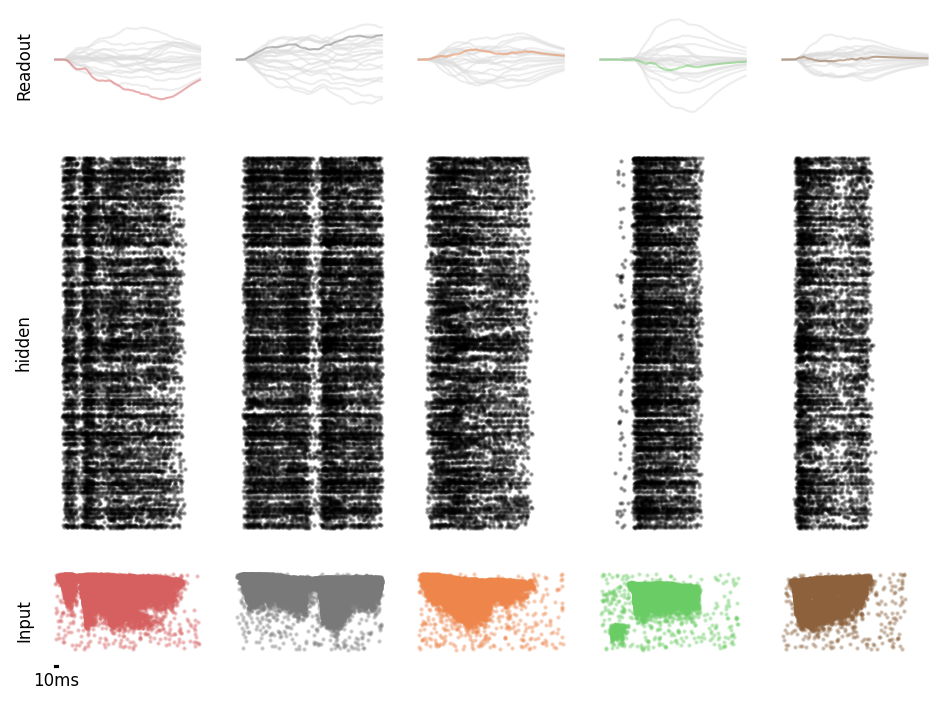

In [18]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model, data=test_dataset, nb_samples=5, point_alpha=0.3
)

## Train

It takes around 50 min using a powerful GPU

In [49]:
history = model.fit_validate(
    train_dataset, valid_dataset, nb_epochs=nb_epochs, verbose=True
)

00  loss=0.146 reg_loss=2.11e-05 acc=0.971 -- val_loss=0.0794 val_reg_loss=2.23e-05 val_acc=0.983 t_iter=19.52
01  loss=0.123 reg_loss=2.11e-05 acc=0.975 -- val_loss=0.111 val_reg_loss=2.24e-05 val_acc=0.984 t_iter=19.70
02  loss=0.169 reg_loss=2.11e-05 acc=0.967 -- val_loss=0.131 val_reg_loss=2.23e-05 val_acc=0.982 t_iter=18.99
03  loss=0.16 reg_loss=2.11e-05 acc=0.967 -- val_loss=0.109 val_reg_loss=2.24e-05 val_acc=0.977 t_iter=18.87
04  loss=0.157 reg_loss=2.12e-05 acc=0.97 -- val_loss=0.13 val_reg_loss=2.24e-05 val_acc=0.982 t_iter=19.54
05  loss=0.134 reg_loss=2.12e-05 acc=0.971 -- val_loss=0.0884 val_reg_loss=2.25e-05 val_acc=0.981 t_iter=19.02
06  loss=0.142 reg_loss=2.12e-05 acc=0.969 -- val_loss=0.138 val_reg_loss=2.26e-05 val_acc=0.976 t_iter=18.96
07  loss=0.16 reg_loss=2.12e-05 acc=0.967 -- val_loss=0.0706 val_reg_loss=2.25e-05 val_acc=0.986 t_iter=18.97
08  loss=0.143 reg_loss=2.12e-05 acc=0.972 -- val_loss=0.105 val_reg_loss=2.26e-05 val_acc=0.983 t_iter=19.86
09  loss=0.

In [50]:
if "train_loss" in results:
    results["train_loss"] += history["loss"].tolist()
    results["train_acc"] += history["acc"].tolist()
    results["valid_loss"] += history["val_loss"].tolist()
    results["valid_acc"] += history["val_acc"].tolist()
else:
    results["train_loss"] = history["loss"].tolist()
    results["train_acc"] = history["acc"].tolist()
    results["valid_loss"] = history["val_loss"].tolist()
    results["valid_acc"] = history["val_acc"].tolist()

Monitor the model again after training

In [51]:
res = model.monitor(test_dataset)
total_spikes_per_layer = [torch.sum(res[i]).item() for i in range(nb_hidden_layers)]
results["avg_layer_freq"] = [
    nb / len(test_dataset) / duration / nb_hidden_units for nb in total_spikes_per_layer
]

print(results["avg_layer_freq"])

[18.13796249921126]


## Test

In [52]:
scores = model.evaluate(test_dataset).tolist()
results["test_loss"], _, results["test_acc"] = scores

Test loss:  0.6450682481129965
Test acc.:  0.9140303497942388


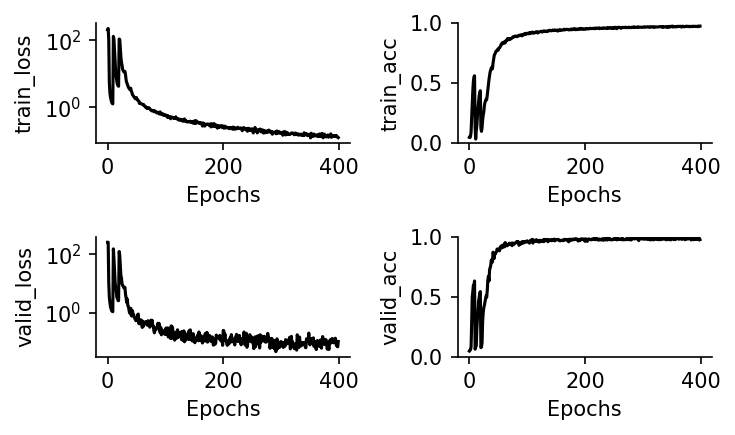

In [53]:
fig, ax = plt.subplots(2, 2, figsize=(5, 3), dpi=150)

for i, n in enumerate(["train_loss", "train_acc", "valid_loss", "valid_acc"]):

    if i < 2:
        a = ax[0][i]
    else:
        a = ax[1][i - 2]

    a.plot(results[n], color="black")
    a.set_xlabel("Epochs")
    a.set_ylabel(n)

    if "loss" in n:
        a.set_yscale("log")

ax[0, 1].set_ylim(0, 1)
ax[1, 1].set_ylim(0, 1)

sns.despine()
plt.tight_layout()

print("Test loss: ", results["test_loss"])
print("Test acc.: ", results["test_acc"])

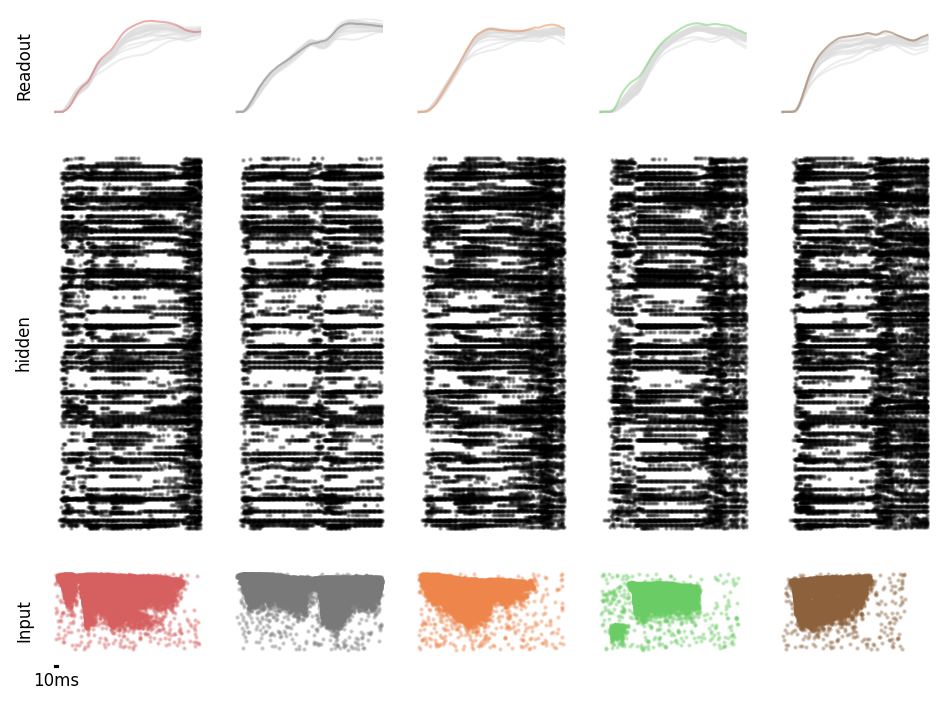

In [48]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model, data=test_dataset, nb_samples=5, point_alpha=0.3
)

In [26]:
t = 0
for i in range(10):
    t += 10*2**i
    print(10*2**i, "\t", t)

10 	 10
20 	 30
40 	 70
80 	 150
160 	 310
320 	 630
640 	 1270
1280 	 2550
2560 	 5110
5120 	 10230
